In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, Normalizer
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error as mse

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s3e8/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e8/test.csv')
sub = pd.read_csv('/kaggle/input/playground-series-s3e8/sample_submission.csv')
extra = pd.read_csv('/kaggle/input/gemstone-price-prediction/cubic_zirconia.csv')
train.drop(columns=['id'],inplace=True)
test.drop(columns=['id'],inplace=True)
extra.drop(columns=['Unnamed: 0'],inplace=True)
extra.dropna(inplace=True)

In [3]:
df = pd.concat([train,extra])

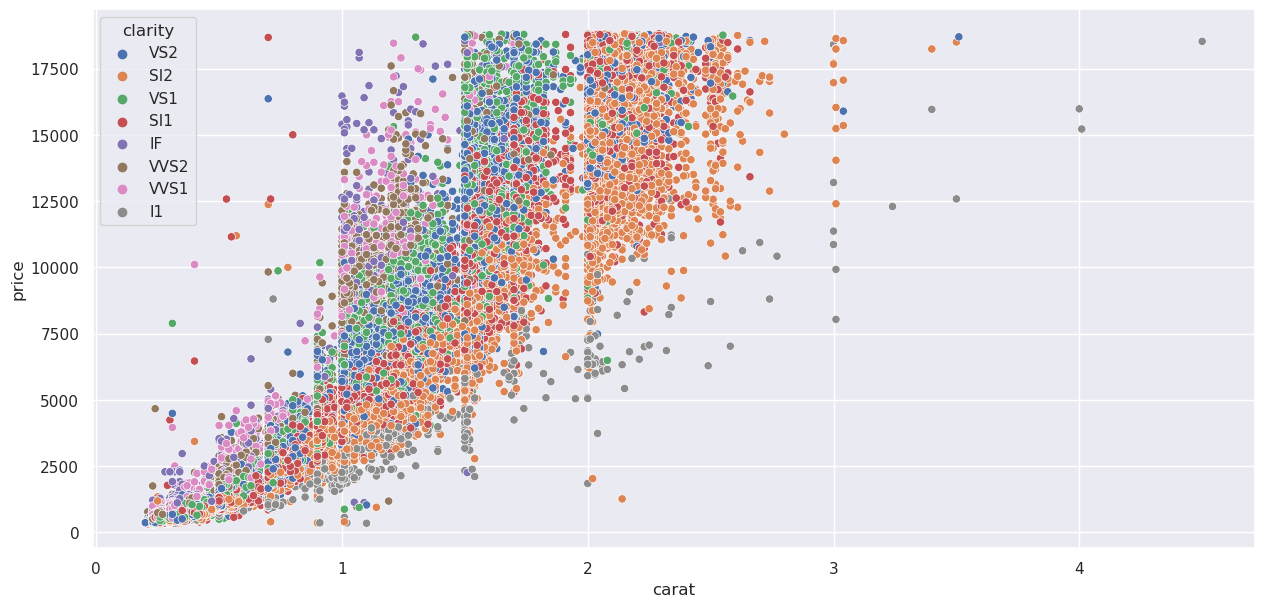

In [4]:
sns.set(rc={'figure.figsize':(15,7)})
sns.scatterplot(data=df, x="carat", y="price", hue="clarity");

In [5]:
df = pd.concat([train,extra,test])

In [6]:
def encoder(data):
    le = LabelEncoder()
    le.fit(data)
    return le.transform(data)    

def normal(data):
    transformer = Normalizer().fit(data) 
    return transformer.transform(data)

In [7]:
df['cut'] = encoder(df['cut'])
df['color'] = encoder(df['color'])
df['clarity'] = encoder(df['clarity'])

In [8]:
df.drop(df[(df['price'] > 10000) & (df['carat'] > 0)  & (df['carat'] < 1)].index, inplace=True)

In [9]:
df_train = df.iloc[:-len(test),:]
df_test = df.iloc[-len(test):,:]

X = df_train.drop(['price'], axis=1)
y = df_train.price

X_test = df_test.drop('price', axis=1)

In [10]:
std_ = StandardScaler()
mms_ = MinMaxScaler()
mas_ = MaxAbsScaler()
rbs_ = RobustScaler()
nml_ = Normalizer()

X_std = std_.fit_transform(X)
X_mms = mms_.fit_transform(X)
X_mas = mas_.fit_transform(X)
X_rbs = rbs_.fit_transform(X)
X_nml = nml_.fit_transform(X)

df_result = pd.DataFrame(columns=['model','scale','mse'])

def train_test(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=.85,random_state=2023)
    return x_train, x_test, y_train, y_test

def train_model(x,y, model,n_model, scale):
    x_train, x_test, y_train, y_test = train_test(x,y)
    model.fit(x_train, y_train, verbose=0)
    pred = model.predict(x_test)
    new_ = {'model':str(n_model),'scale':scale,'mse':mse(pred, y_test)}
    return new_, model

In [11]:
xgb = XGBRegressor()

dic, xgb_model_std = train_model(X_std,y,xgb,'XGBRegressor','StandardScaler')
df_result = df_result.append(dic, ignore_index=True)

dic, xgb_model_mms = train_model(X_mms,y,xgb,'XGBRegressor','MinMaxScaler')
df_result = df_result.append(dic, ignore_index=True)

dic, xgb_model_mas = train_model(X_mas,y,xgb,'XGBRegressor','MaxAbsScaler')
df_result = df_result.append(dic, ignore_index=True)

dic, xgb_model_rbs = train_model(X_rbs,y,xgb,'XGBRegressor','RobustScaler')
df_result = df_result.append(dic, ignore_index=True)

dic, xgb_model_nml = train_model(X_nml,y,xgb,'XGBRegressor','Normalizer')
df_result = df_result.append(dic, ignore_index=True)

In [12]:
cat = CatBoostRegressor()

dic, cat_model_std = train_model(X_std,y,cat,'CatBoostRegressor','StandardScaler')
df_result = df_result.append(dic, ignore_index=True)

dic, cat_model_mms = train_model(X_mms,y,cat,'CatBoostRegressor','MinMaxScaler')
df_result = df_result.append(dic, ignore_index=True)

dic, cat_model_mas = train_model(X_mas,y,cat,'CatBoostRegressor','MaxAbsScaler')
df_result = df_result.append(dic, ignore_index=True)

dic, cat_model_rbs = train_model(X_rbs,y,cat,'CatBoostRegressor','RobustScaler')
df_result = df_result.append(dic, ignore_index=True)

dic, cat_model_nml = train_model(X_nml,y,cat,'CatBoostRegressor','Normalizer')
df_result = df_result.append(dic, ignore_index=True)

In [13]:
lgb = LGBMRegressor()

dic, lgb_model_std = train_model(X_std,y,cat,'LGBMRegressor','StandardScaler')
df_result = df_result.append(dic, ignore_index=True)

dic, lgb_model_mms = train_model(X_mms,y,cat,'LGBMRegressor','MinMaxScaler')
df_result = df_result.append(dic, ignore_index=True)

dic, lgb_model_mas = train_model(X_mas,y,cat,'LGBMRegressor','MaxAbsScaler')
df_result = df_result.append(dic, ignore_index=True)

dic, lgb_model_rbs = train_model(X_rbs,y,cat,'LGBMRegressor','RobustScaler')
df_result = df_result.append(dic, ignore_index=True)

dic, lgb_model_nml = train_model(X_nml,y,cat,'LGBMRegressor','Normalizer')
df_result = df_result.append(dic, ignore_index=True)

In [14]:
df_result.sort_values(by='mse', ascending=True)

,model,scale,mse
6,CatBoostRegressor,MinMaxScaler,322163.130639
7,CatBoostRegressor,MaxAbsScaler,322163.130639
8,CatBoostRegressor,RobustScaler,322163.130639
11,LGBMRegressor,MinMaxScaler,322163.130639
12,LGBMRegressor,MaxAbsScaler,322163.130639
13,LGBMRegressor,RobustScaler,322163.130639
5,CatBoostRegressor,StandardScaler,322174.319112
10,LGBMRegressor,StandardScaler,322174.319112
0,XGBRegressor,StandardScaler,333616.100282
3,XGBRegressor,RobustScaler,333802.231971


In [15]:
sub['price'] = cat_model_mms.predict(X_test)
sub.to_csv('submission.csv',index=False)